In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
class Loader:

    def __init__(self, files):
        self.files = files

    def get_data(self):
        dfs = []
        for file in self.files:
            df = self.load_past_matches(file)
            dfs.append(df)
        
        df_join = self.join_data(dfs[0], dfs[1])

        return df_join

    def load_past_matches(self, file):
        df = pd.read_csv(f'../../data/{file}')
        df.drop('Unnamed: 0', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date']).dt.date

        return df

    def join_data(self, df1, df2):
        df = pd.merge(df1, df2,  how='inner',
            left_on=['league', 'date','team', 'opponent', 'home'],
            right_on=['league', 'date','team', 'opponent', 'home'])
        df.sort_values(by=['date', 'league', 'team', 'opponent'], inplace=True)
        df.reset_index(inplace=True, drop=True)
              
        return df

In [3]:
FILES = ["elos_matches.csv", "goals_matches.csv"]
loader = Loader(FILES)
data = loader.get_data()

In [4]:
data.drop(['team_goals_scored',
           'opponent_goals_scored',
           'team_goals_conceded',
           'opponent_goals_conceded'], axis=1, inplace=True)

In [5]:
def build_dataset(df):
    df_copy = df.copy()
    df_copy.reset_index(inplace=True, drop=True)
    date = df_copy[['date']].iloc[:,-1]
    df_copy.drop(['league', 'date', 'team', 'opponent'], axis=1, inplace=True)
    df_copy['date'] = date
    df_copy.sort_values(by=['date'], inplace=True)
    df_copy.drop(['date'], axis=1, inplace=True)
    
    X = df_copy.drop(['result'], axis=1).to_numpy()
    Y = np.array(df_copy['result']) / 0.5
    
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).long()
    
    return X, Y

In [6]:
def get_first_column(df, column):
#     df_copy = df.copy()
    column_data = df[column].iloc[:,0]
    df.drop([column], axis=1, inplace=True)
    df[column] = column_data

In [7]:
def add_past_to_row(df, i):
    df_past = df.copy()
    df_past.index += i
    df_past.rename(columns={c: c+f'_{i}' for c in df_past.columns if c not in ['league',
                                                                               'date',
                                                                               'team',
                                                                               'opponent']}, inplace=True)
    return df_past

In [8]:
def build_matches_dataset(df, past_matches, team):
    dfs_past = []
    df_team = df[df['team']==team]
    for i in range(1, past_matches+1):
        df_past = add_past_to_row(df_team, i)
        dfs_past.append(df_past)

    df_team_joined = df_team.copy()
    for df_past in dfs_past:
        df_team_joined = pd.concat([df_team_joined, df_past],
                                    axis=1,
                                    )
    df_team_joined = df_team_joined[past_matches:-past_matches]

    return df_team_joined

In [9]:
def build_teams_dataset(df, past_matches):
    dfs = []
    for team in df['team'].unique():
        df_team_joined = build_matches_dataset(df, past_matches, team)
        dfs.append(df_team_joined)
    dfs = pd.concat(dfs)
    dfs.insert(5, 'result_0', 0)

    return dfs

In [10]:
def build_wavenet_dataset(df, past_matches=7, date=False):
    df_copy = df.copy()
    df_copy.sort_values(by=['team', 'date'], inplace=True)
    df_copy.reset_index(inplace=True, drop=True)
    dfs = build_teams_dataset(df_copy, past_matches)
    if date:
        dfs = dfs[(dfs.iloc[:, 1]>=start_date) & (dfs.iloc[:, 1]<=end_date)].reset_index(drop=True)
        
    dfs.reset_index(inplace=True, drop=True)
    columns = ['date', 'league', 'team', 'opponent']
    for column in columns:
        get_first_column(dfs, column)
    X, Y = build_dataset(dfs)
    
    return X, Y, dfs

#     return dfs

In [11]:
X, Y, dfs = build_wavenet_dataset(data, 7, date=False)

In [12]:
dfs.head()

,result,result_0,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,team_goals_conceded_avg_home,...,team_attack_strength_7,team_defense_strength_7,opponent_attack_strength_7,opponent_defense_strength_7,team_lambda_7,opponent_lambda_7,date,league,team,opponent
0,0.0,0,1434.774322,1420.884751,13.889572,0.0,0.0,0.0,1.315789,1.473684,...,0.849858,2.382979,2.638298,1.053824,1.386611,3.888018,2012-09-15,Serie B,a_s_d_lanciano_calcio_1920,cittadella
1,0.5,0,1413.975200,1397.367869,16.607331,1.0,0.0,0.0,1.315789,1.473684,...,1.739130,1.068352,0.620333,1.106719,1.281465,1.012122,2012-09-22,Serie B,a_s_d_lanciano_calcio_1920,grosseto
2,1.0,0,1413.019933,1416.305471,-3.285539,0.0,0.0,0.0,1.315789,1.473684,...,0.594059,1.043478,0.000000,0.000000,0.000000,0.000000,2012-09-25,Serie B,a_s_d_lanciano_calcio_1920,reggina
3,0.5,0,1433.209058,1466.391567,-33.182509,1.0,0.0,0.0,1.315789,1.473684,...,0.843810,0.683154,0.771303,0.958875,1.110276,1.258441,2012-09-29,Serie B,a_s_d_lanciano_calcio_1920,modena
4,0.0,0,1435.113410,1445.490202,-10.376792,0.0,0.0,0.0,1.315789,1.473684,...,0.805742,1.101342,0.710543,1.135363,1.314631,1.159308,2012-10-06,Serie B,a_s_d_lanciano_calcio_1920,brescia


In [13]:
# data[(data['team']=='a_s_d_lanciano_calcio_1920') & (data['opponent']=='cittadella')]

In [14]:
# dfs[(dfs['team']=='a_s_d_lanciano_calcio_1920') & (dfs['opponent']=='cittadella')]

In [16]:
PATH = "../../src/model/trained_models/wavenet_5.pt"
# model.load_state_dict(torch.load(PATH))
model = torch.load(PATH)
model.train()

Sequential(
  (0): Conv1d(1, 32, kernel_size=(31,), stride=(31,))
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): Conv1d(32, 64, kernel_size=(2,), stride=(2,))
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Tanh()
  (6): Conv1d(64, 128, kernel_size=(2,), stride=(2,))
  (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Tanh()
  (9): Conv1d(128, 256, kernel_size=(2,), stride=(2,))
  (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Tanh()
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=256, out_features=3, bias=True)
)

In [17]:
@torch.no_grad()
def get_single_prediction(x, y):
#     x, y = {
#         'train': [Xtr, Ytr],
#         'val'  : [Xdev, Ydev],
#         'test' : [Xte, Yte]
#     }[split]
    
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.argmax(logits, dim=1)

    i = 0
    for pred, true in zip(preds, y):
        if pred == true:
            i += 1
    
#     print(f"----{split}----")
    print(f"Correctly predicted {i} out of {y.shape[0]}.")
    print(f"{i / y.shape[0]:.4f}")
    print(f"Guessing would give an accuracy of {1 / len(torch.unique(y))}")
    
    return preds

In [18]:
@torch.no_grad()
def get_predictions(x, df):
    x = x[:, None, :]
    logits = model(x)
    preds = []
    preds = torch.softmax(logits, dim=1)
    print(preds)
#     print(preds.numpy())
#     print(pd.DataFrame(preds.numpy()))
    df[['loss', 'draw', 'win']] = pd.DataFrame(preds.numpy())
    
    return df

In [19]:
dfs_preds = dfs.copy()
dfs_preds = dfs_preds[['date', 'team', 'opponent',
                       'result', 'elo_team', 'elo_opponent', 'elo_diff', 'home',
                       'team_goals_scored_avg', 'team_goals_conceded_avg', 'team_goals_scored_avg_home',
                       ]]
# date = dfs_preds.iloc[:, 1]
# dfs_preds.drop('date', axis=1, inplace=True)
# dfs_preds['date'] = date
dfs_preds.sort_values('date', inplace=True)
dfs_preds.reset_index(inplace=True, drop=True)
dfs_preds = get_predictions(X, dfs_preds)

tensor([[0.8356, 0.1333, 0.0310],
        [0.5786, 0.2815, 0.1399],
        [0.2018, 0.1104, 0.6877],
        ...,
        [0.0939, 0.7056, 0.2005],
        [0.3339, 0.6098, 0.0563],
        [0.1097, 0.7161, 0.1742]])


In [20]:
dfs_preds.tail()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win
71473,2023-01-21,cittadella,cagliari,0.5,1397.092249,1482.353487,-85.261238,1.0,0.473684,1.578947,0.736842,0.055867,0.763546,0.180588
71474,2023-01-21,spal,ascoli,0.5,1460.861033,1437.718312,23.142721,1.0,0.947368,1.052632,1.473684,0.094261,0.677994,0.227745
71475,2023-01-21,benevento,genoa,0.5,1448.032246,1506.722755,-58.690509,1.0,0.947368,1.052632,1.368421,0.093856,0.705631,0.200513
71476,2023-01-22,frosinone,brescia,0.5,1534.508235,1396.400872,138.107363,0.0,1.421053,0.631579,1.894737,0.333937,0.609769,0.056294
71477,2023-01-22,brescia,frosinone,0.5,1396.400872,1534.508235,-138.107363,1.0,0.684211,1.526316,1.368421,0.109703,0.716130,0.174167


In [21]:
dfs_preds_cut = dfs_preds.copy()
# dfs_preds_cut = dfs_preds.iloc[:, 0:9]
# dfs_preds_cut.drop(['result_0'], axis=1, inplace=True)
# dfs_preds_cut['date'] = date
# dfs_preds_cut[['loss', 'draw', 'win']] = dfs_preds[['loss', 'draw', 'win']]

In [22]:
dfs_preds_cut.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win
0,1997-11-09,empoli,parma,0.0,1472.917207,1551.843017,-78.925811,0.0,0.0,0.0,1.736842,0.835637,0.133346,0.031017
1,1997-11-09,brescia,milan,0.0,1498.152602,1479.411525,18.741076,0.0,0.0,0.0,1.526316,0.578593,0.281502,0.139905
2,1997-11-09,bari,roma,0.0,1464.290814,1525.651095,-61.360281,1.0,0.0,0.0,0.684211,0.201839,0.110417,0.687744
3,1997-11-09,piacenza,udinese,0.0,1433.150516,1503.364301,-70.213785,0.0,0.0,0.0,0.842105,0.808288,0.148100,0.043612
4,1997-11-09,napoli,juventus,0.0,1441.459893,1575.166302,-133.706409,1.0,0.0,0.0,0.789474,0.298489,0.235813,0.465698


In [23]:
dfs_preds_cut['prediction'] = dfs_preds_cut[['loss', 'draw', 'win']].idxmax(axis=1)
dfs_preds_cut['prediction'] = dfs_preds_cut['prediction'].replace({'win': 1, 'draw': 0.5, 'loss': 0})
dfs_preds_cut['correct'] = np.where((dfs_preds_cut['result'] == dfs_preds_cut['prediction']), 1, 0)

In [24]:
dfs_preds_cut['correct'].mean()

0.599093427348275

In [25]:
dfs_preds_cut.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct
0,1997-11-09,empoli,parma,0.0,1472.917207,1551.843017,-78.925811,0.0,0.0,0.0,1.736842,0.835637,0.133346,0.031017,0.0,1
1,1997-11-09,brescia,milan,0.0,1498.152602,1479.411525,18.741076,0.0,0.0,0.0,1.526316,0.578593,0.281502,0.139905,0.0,1
2,1997-11-09,bari,roma,0.0,1464.290814,1525.651095,-61.360281,1.0,0.0,0.0,0.684211,0.201839,0.110417,0.687744,1.0,0
3,1997-11-09,piacenza,udinese,0.0,1433.150516,1503.364301,-70.213785,0.0,0.0,0.0,0.842105,0.808288,0.148100,0.043612,0.0,1
4,1997-11-09,napoli,juventus,0.0,1441.459893,1575.166302,-133.706409,1.0,0.0,0.0,0.789474,0.298489,0.235813,0.465698,1.0,0


In [26]:
dfs_preds_cut.sort_values(by='date').tail()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct
71462,2023-01-21,sudtirol,venezia,0.5,1505.931774,1432.182730,73.749044,0.0,0.000000,0.000000,0.000000,0.158997,0.809314,0.031689,0.5,1
71461,2023-01-21,ternana,reggina,0.5,1445.953023,1493.083841,-47.130819,0.0,0.947368,0.947368,1.263158,0.206211,0.664206,0.129584,0.5,1
71467,2023-01-21,reggina,ternana,0.5,1493.083841,1445.953023,47.130819,1.0,1.421053,0.894737,1.736842,0.081783,0.838726,0.079491,0.5,1
71476,2023-01-22,frosinone,brescia,0.5,1534.508235,1396.400872,138.107363,0.0,1.421053,0.631579,1.894737,0.333937,0.609769,0.056294,0.5,1
71477,2023-01-22,brescia,frosinone,0.5,1396.400872,1534.508235,-138.107363,1.0,0.684211,1.526316,1.368421,0.109703,0.716130,0.174167,0.5,1


In [27]:
dfs_preds_cut[(dfs_preds_cut['team']=='sampdoria') & (dfs_preds_cut['opponent']=='inter_milan')]

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct
55,1997-12-06,sampdoria,inter_milan,0.5,1510.571197,1612.781815,-102.210618,1.0,0.000000,0.000000,1.842105,0.403701,0.346529,0.249770,0.0,0
364,1998-04-05,sampdoria,inter_milan,0.0,1484.173961,1600.691580,-116.517619,0.0,1.526316,1.684211,1.842105,0.816081,0.131308,0.052612,0.0,1
603,1998-11-15,sampdoria,inter_milan,0.0,1505.177302,1576.663758,-71.486456,0.0,1.210526,1.631579,1.894737,0.925368,0.050355,0.024276,0.0,1
909,1999-03-21,sampdoria,inter_milan,1.0,1434.012845,1549.279868,-115.267023,1.0,0.736842,1.631579,1.315789,0.067139,0.059421,0.873439,1.0,1
3873,2003-09-21,sampdoria,inter_milan,0.5,1477.305145,1665.081792,-187.776647,0.0,1.263158,1.473684,1.421053,0.594941,0.297853,0.107206,0.0,0
4284,2004-02-08,sampdoria,inter_milan,0.5,1533.826582,1575.821686,-41.995104,1.0,1.157895,1.210526,1.526316,0.043486,0.130567,0.825947,1.0,0
5115,2005-01-09,sampdoria,inter_milan,0.0,1565.691378,1618.156078,-52.464701,0.0,1.210526,0.578947,1.000000,0.859941,0.072126,0.067934,0.0,1
5660,2005-05-22,sampdoria,inter_milan,0.0,1561.353156,1680.522624,-119.169468,1.0,1.210526,0.736842,1.263158,0.553355,0.243575,0.203070,0.0,1
5971,2005-10-29,sampdoria,inter_milan,0.5,1506.779560,1673.706211,-166.926651,1.0,1.578947,1.315789,1.578947,0.465675,0.371636,0.162689,0.0,0
6520,2006-03-11,sampdoria,inter_milan,0.0,1482.925035,1686.700795,-203.775760,0.0,1.052632,1.263158,1.631579,0.799345,0.151711,0.048945,0.0,1


In [28]:
odds = pd.read_csv("betting_data/odds_2021_2022.csv", index_col=0, parse_dates=['date'], dayfirst=False)
odds['date'] = pd.to_datetime(odds['date']).dt.date
odds.drop(['prediction', 'home', 'league'], axis=1, inplace=True)
# odds[odds['league']=='Serie A'].tail()

In [29]:
odds.shape

(1538, 8)

In [30]:
dfs_preds_cut.shape

(71478, 16)

In [31]:
joined = pd.merge(dfs_preds_cut, odds, left_on=['team', 'opponent', 'date', 'result'],
                 right_on=['team', 'opponent', 'date', 'result'])
joined.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct,match_id,team_odds,opponent_odds,draw_odds
0,2021-08-13,perugia,genoa,0.0,1590.867274,1544.566014,46.301260,0.0,1.842105,0.526316,2.157895,0.544546,0.125701,0.329753,0.0,1,genoa_perugia_2021-08-13,0.239923,0.653595,0.294118
1,2021-08-13,genoa,perugia,1.0,1544.566014,1590.867274,-46.301260,1.0,1.263158,1.736842,1.473684,0.245352,0.115767,0.638881,1.0,1,genoa_perugia_2021-08-13,0.653595,0.239923,0.294118
2,2021-08-13,pordenone_calcio,spezia,0.0,1445.066543,1554.964373,-109.897830,1.0,0.947368,1.263158,1.421053,0.105627,0.138739,0.755634,1.0,0,pordenone_calcio_spezia_2021-08-13,0.381679,0.444444,0.333333
3,2021-08-13,udinese,ascoli,1.0,1507.819644,1495.395651,12.423993,1.0,1.105263,1.894737,0.631579,0.101686,0.259546,0.638768,1.0,1,ascoli_udinese_2021-08-13,0.750751,0.161708,0.251509
4,2021-08-13,ascoli,udinese,0.0,1495.395651,1507.819644,-12.423993,0.0,1.210526,1.263158,0.947368,0.904203,0.049043,0.046754,0.0,1,ascoli_udinese_2021-08-13,0.161708,0.750751,0.251509


In [32]:
joined['team_odds'] = 1/joined['team_odds']
joined['opponent_odds'] = 1/joined['opponent_odds']
joined['draw_odds'] = 1/joined['draw_odds']

In [33]:
joined.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct,match_id,team_odds,opponent_odds,draw_odds
0,2021-08-13,perugia,genoa,0.0,1590.867274,1544.566014,46.301260,0.0,1.842105,0.526316,2.157895,0.544546,0.125701,0.329753,0.0,1,genoa_perugia_2021-08-13,4.168,1.530,3.400
1,2021-08-13,genoa,perugia,1.0,1544.566014,1590.867274,-46.301260,1.0,1.263158,1.736842,1.473684,0.245352,0.115767,0.638881,1.0,1,genoa_perugia_2021-08-13,1.530,4.168,3.400
2,2021-08-13,pordenone_calcio,spezia,0.0,1445.066543,1554.964373,-109.897830,1.0,0.947368,1.263158,1.421053,0.105627,0.138739,0.755634,1.0,0,pordenone_calcio_spezia_2021-08-13,2.620,2.250,3.000
3,2021-08-13,udinese,ascoli,1.0,1507.819644,1495.395651,12.423993,1.0,1.105263,1.894737,0.631579,0.101686,0.259546,0.638768,1.0,1,ascoli_udinese_2021-08-13,1.332,6.184,3.976
4,2021-08-13,ascoli,udinese,0.0,1495.395651,1507.819644,-12.423993,0.0,1.210526,1.263158,0.947368,0.904203,0.049043,0.046754,0.0,1,ascoli_udinese_2021-08-13,6.184,1.332,3.976


In [34]:
joined.shape

(1499, 20)

In [35]:
def get_pred_odds(row):
    if row['prediction'] == 1:
        return row['team_odds']
    elif row['prediction'] == 0:
        return row['opponent_odds']
    else:
        return row['draw_odds']

In [36]:
joined['odds_bet'] = joined.apply(lambda x: get_pred_odds(x), axis=1)
joined['pot'] = 100

In [37]:
joined.tail()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,...,draw,win,prediction,correct,match_id,team_odds,opponent_odds,draw_odds,odds_bet,pot
1494,2022-05-25,cassino,lanusei,1.0,1514.810830,1385.902658,128.908171,1.0,0.000000,0.000000,...,0.067763,0.897840,1.0,1,cassino_lanusei_2022-05-25,2.05,2.632,2.88,2.05,100
1495,2022-05-29,lentigione,ravenna,1.0,1567.392668,1464.070415,103.322253,0.0,1.947368,1.368421,...,0.047251,0.939670,1.0,1,lentigione_ravenna_2022-05-29,3.10,1.710,3.10,3.10,100
1496,2022-05-29,ravenna,lentigione,0.0,1464.070415,1567.392668,-103.322253,1.0,1.736842,1.105263,...,0.007739,0.004782,0.0,1,lentigione_ravenna_2022-05-29,1.71,3.100,3.10,3.10,100
1497,2022-07-31,modena,catanzaro,1.0,1579.130139,1536.004777,43.125362,1.0,1.631579,0.526316,...,0.047297,0.899247,1.0,1,catanzaro_modena_2022-07-31,1.62,3.500,3.10,1.62,100
1498,2022-07-31,catanzaro,modena,0.0,1536.004777,1579.130139,-43.125362,0.0,1.736842,0.789474,...,0.043257,0.051436,0.0,1,catanzaro_modena_2022-07-31,3.50,1.620,3.10,1.62,100


In [38]:
joined.shape[0]

1499

In [39]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined.iterrows():
    if row['correct'] == 1:
        round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
    else:
        round_winnings = - bet_pct * pot[index]
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])

In [40]:
joined['pot'] = pot[:-1]
joined['win'] = win

In [41]:
joined.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,...,draw,win,prediction,correct,match_id,team_odds,opponent_odds,draw_odds,odds_bet,pot
0,2021-08-13,perugia,genoa,0.0,1590.867274,1544.566014,46.301260,0.0,1.842105,0.526316,...,0.125701,0.530000,0.0,1,genoa_perugia_2021-08-13,4.168,1.530,3.400,1.530,100.000000
1,2021-08-13,genoa,perugia,1.0,1544.566014,1590.867274,-46.301260,1.0,1.263158,1.736842,...,0.115767,0.532809,1.0,1,genoa_perugia_2021-08-13,1.530,4.168,3.400,1.530,100.530000
2,2021-08-13,pordenone_calcio,spezia,0.0,1445.066543,1554.964373,-109.897830,1.0,0.947368,1.263158,...,0.138739,-1.010628,1.0,0,pordenone_calcio_spezia_2021-08-13,2.620,2.250,3.000,2.620,101.062809
3,2021-08-13,udinese,ascoli,1.0,1507.819644,1495.395651,12.423993,1.0,1.105263,1.894737,...,0.259546,0.332173,1.0,1,ascoli_udinese_2021-08-13,1.332,6.184,3.976,1.332,100.052181
4,2021-08-13,ascoli,udinese,0.0,1495.395651,1507.819644,-12.423993,0.0,1.210526,1.263158,...,0.049043,0.333276,0.0,1,ascoli_udinese_2021-08-13,6.184,1.332,3.976,1.332,100.384354


In [42]:
joined.tail()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,...,draw,win,prediction,correct,match_id,team_odds,opponent_odds,draw_odds,odds_bet,pot
1494,2022-05-25,cassino,lanusei,1.0,1514.810830,1385.902658,128.908171,1.0,0.000000,0.000000,...,0.067763,26.615666,1.0,1,cassino_lanusei_2022-05-25,2.05,2.632,2.88,2.05,2534.825352
1495,2022-05-29,lentigione,ravenna,1.0,1567.392668,1464.070415,103.322253,0.0,1.947368,1.368421,...,0.047251,53.790261,1.0,1,lentigione_ravenna_2022-05-29,3.10,1.710,3.10,3.10,2561.441018
1496,2022-05-29,ravenna,lentigione,0.0,1464.070415,1567.392668,-103.322253,1.0,1.736842,1.105263,...,0.007739,54.919857,0.0,1,lentigione_ravenna_2022-05-29,1.71,3.100,3.10,3.10,2615.231280
1497,2022-07-31,modena,catanzaro,1.0,1579.130139,1536.004777,43.125362,1.0,1.631579,0.526316,...,0.047297,16.554937,1.0,1,catanzaro_modena_2022-07-31,1.62,3.500,3.10,1.62,2670.151137
1498,2022-07-31,catanzaro,modena,0.0,1536.004777,1579.130139,-43.125362,0.0,1.736842,0.789474,...,0.043257,16.657578,0.0,1,catanzaro_modena_2022-07-31,3.50,1.620,3.10,1.62,2686.706074


In [43]:
pd.options.display.float_format = '{:.2f}'.format

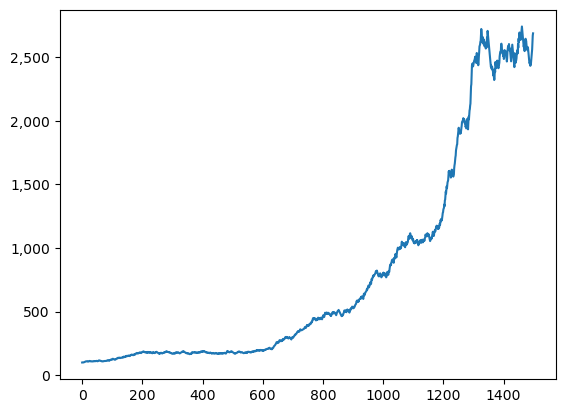

In [44]:
fig, ax = plt.subplots()
ax.plot(joined['pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

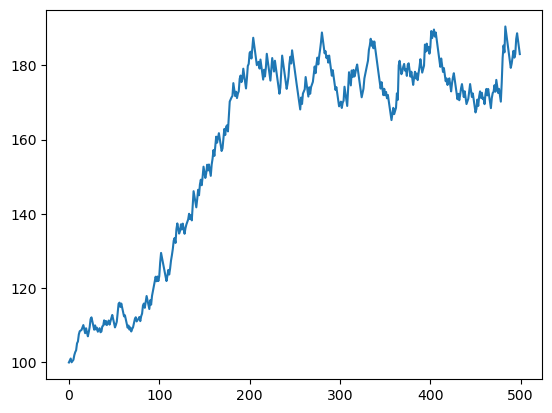

In [45]:
fig, ax = plt.subplots()
ax.plot(pot[:500])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

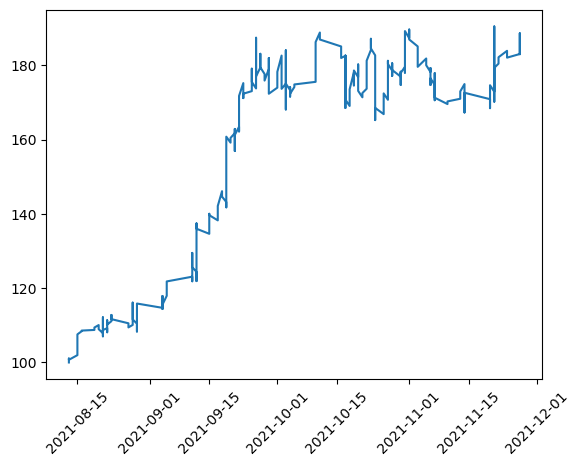

In [46]:
date = joined['date'].tolist()

fig, ax = plt.subplots()
ax.plot(date[:500], pot[:500])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

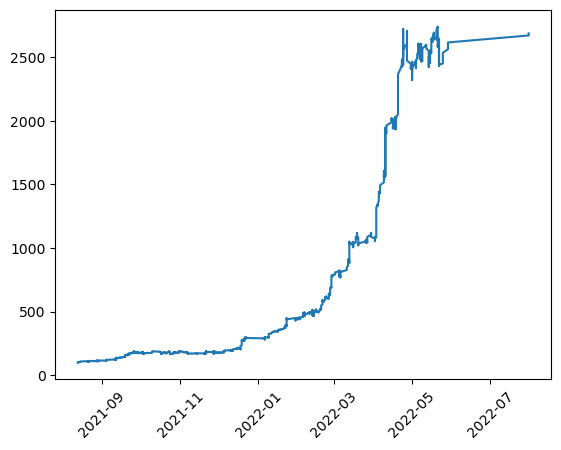

In [47]:
fig, ax = plt.subplots()
ax.plot(date, pot[:-1])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

## Football-data.co.uk Betting Data

In [48]:
odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
odds_fd = odds_fd.loc[:,~odds_fd.columns.str.contains('Unnamed')]
odds_fd.dropna(subset='home_team', inplace=True)
odds_fd['date'] = pd.to_datetime(odds_fd['date']).dt.date
odds_fd['home_team'] = odds_fd['home_team'].replace(' ', '_', regex=True).str.lower()
odds_fd['away_team'] = odds_fd['away_team'].replace(' ', '_', regex=True).str.lower()
odds_fd = odds_fd[['div', 'date', 'home_team', 'away_team', 'FTR', 'B365H', 'B365D', 'B365A']]
odds_fd.head()

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/931263150.py:1: DtypeWarning: Columns (3,11,118,145) have mixed types. Specify dtype option on import or set low_memory=False.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/931263150.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)


,div,date,home_team,away_team,FTR,B365H,B365D,B365A
0,I1,2022-08-13,milan,udinese,H,1.44,4.75,7.00
1,I1,2022-08-13,sampdoria,atalanta,A,4.33,3.90,1.75
2,I1,2022-08-13,lecce,inter,A,10.00,5.75,1.28
3,I1,2022-08-13,monza,torino,A,2.60,3.30,2.75
4,I1,2022-08-14,fiorentina,cremonese,H,1.36,5.00,8.50


In [49]:
conditions  = [odds_fd['FTR']=='H', odds_fd['FTR']=='D', odds_fd['FTR']=='A']
choices     = [1, 0.5, 0]
odds_fd['FTR'] = np.select(conditions, choices)

In [50]:
odds_fd.rename(columns={'FTR': 'result',
                        'B365H': 'team_odds',
                        'B365A': 'opponent_odds',
                        'B365D': 'draw_odds'}, inplace=True)


In [51]:
def duplicate_to_team_and_opponent(df_matches):
#     df_matches = df_matches[['div', 'date', 'home_team', 'away_team', 'FTHG', 'FTAG']]
#     df_matches['FTHG_conceded'] = df_matches['FTAG']
#     df_matches['FTAG_conceded'] = df_matches['FTHG']

    df_matches_copy = df_matches.copy()
    df_matches = df_matches.rename(columns={'home_team': 'team', 'away_team': 'opponent'})
    df_matches_copy = df_matches_copy.rename(columns={'away_team': 'team', 'home_team': 'opponent', 'team_odds': 'opponent_odds',
                                            'opponent_odds': 'team_odds'})
    df_matches_copy = df_matches_copy[['div', 'date', 'team', 'opponent', 'result', 'team_odds', 'opponent_odds', 'draw_odds'
                        ]]
    df_matches.loc[:, 'home'] = 1
    df_matches_copy.loc[:, 'home'] = 0
    df_matches = df_matches.append(df_matches_copy)
    df_matches.sort_values(by='date', inplace=True)

    return df_matches

In [52]:
odds_fd_t_o = duplicate_to_team_and_opponent(odds_fd)
odds_fd_t_o.tail()

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/4024275721.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_matches = df_matches.append(df_matches_copy)


,div,date,team,opponent,result,team_odds,draw_odds,opponent_odds,home
164,I1,2023-08-01,empoli,lazio,0.50,6.00,4.20,1.53,0
169,I1,2023-09-01,bologna,atalanta,0.00,3.40,3.40,2.15,1
168,I1,2023-09-01,cremonese,verona,1.00,3.80,3.30,2.05,0
169,I1,2023-09-01,atalanta,bologna,0.00,2.15,3.40,3.40,0
168,I1,2023-09-01,verona,cremonese,1.00,2.05,3.30,3.80,1


In [53]:
odds_fd_t_o = odds_fd_t_o[odds_fd_t_o['div']=='I1']

In [54]:
set(odds_fd_t_o['team'].tolist()) - set(dfs_preds_cut['team'].tolist())

{'chievo', 'inter', 'verona'}

In [55]:
joined_fd = pd.merge(dfs_preds_cut, odds_fd_t_o,
                     left_on=['team', 'opponent', 'date', 'result', 'home'],
                     right_on=['team', 'opponent', 'date', 'result', 'home'],
                     how='inner')
joined_fd.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct,div,team_odds,draw_odds,opponent_odds
0,1997-11-22,piacenza,lazio,0.50,1421.14,1532.21,-111.07,1.00,0.00,0.00,0.84,0.32,0.45,0.23,0.50,1,I1,NaN,NaN,NaN
1,1997-11-22,lazio,piacenza,0.50,1532.21,1421.14,111.07,0.00,0.00,0.00,1.79,0.14,0.56,0.30,0.50,1,I1,NaN,NaN,NaN
2,1997-11-23,empoli,atalanta,1.00,1461.27,1492.15,-30.89,1.00,0.00,0.00,1.74,0.24,0.40,0.36,0.50,0,I1,NaN,NaN,NaN
3,1997-11-23,lecce,napoli,1.00,1438.00,1431.96,6.04,1.00,0.00,0.00,1.00,0.20,0.41,0.39,0.50,0,I1,NaN,NaN,NaN
4,1997-11-23,sampdoria,bari,1.00,1499.97,1451.91,48.06,1.00,0.00,0.00,1.84,0.21,0.36,0.43,1.00,1,I1,NaN,NaN,NaN


In [56]:
date = pd.to_datetime('2020-08-01')
joined_fd = joined_fd[joined_fd['date']>=date]

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/964910844.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_fd = joined_fd[joined_fd['date']>=date]


In [57]:
def get_pred_odds(row):
    if row['prediction'] == 1:
        return row['team_odds']
    elif row['prediction'] == 0:
        return row['opponent_odds']
    else:
        return row['draw_odds']
    
joined_fd['odds_bet'] = joined_fd.apply(lambda x: get_pred_odds(x), axis=1)
joined_fd['pot'] = 100

In [58]:
joined_fd[joined_fd['odds_bet'].isna()]

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,...,draw,win,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot
5029,2020-10-18,udinese,parma,1.00,1505.12,1499.01,6.11,1.00,1.00,1.05,...,0.26,0.37,0.00,0,I1,NaN,NaN,NaN,NaN,100


In [59]:
joined_fd.dropna(subset='team_odds', inplace=True)
joined_fd[joined_fd['team_odds'].isna()]

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,...,draw,win,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot


In [60]:
joined_fd.reset_index(inplace=True, drop=True)

In [61]:
joined_fd['correct'].mean()

0.49828178694158076

In [62]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_fd.iterrows():
    if row['correct'] == 1:
        round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
    else:
        round_winnings = - bet_pct * pot[index]
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])

In [63]:
joined_fd

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,...,draw,win,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot
0,2020-09-19,fiorentina,torino,1.00,1559.04,1482.59,76.46,1.00,1.47,1.00,...,0.04,0.96,1.00,1,I1,1.83,3.75,4.20,1.83,100
1,2020-09-20,sassuolo,cagliari,0.50,1547.87,1483.07,64.81,1.00,2.16,1.74,...,0.04,0.91,1.00,0,I1,1.95,3.75,3.75,1.95,100
2,2020-09-20,juventus,sampdoria,1.00,1539.27,1500.08,39.19,1.00,1.84,1.58,...,0.06,0.91,1.00,1,I1,1.28,5.50,10.50,1.28,100
3,2020-09-20,cagliari,sassuolo,0.50,1483.07,1547.87,-64.81,0.00,1.00,1.63,...,0.15,0.06,0.00,0,I1,3.75,3.75,1.95,1.95,100
4,2020-09-20,parma,napoli,0.00,1513.98,1597.03,-83.05,1.00,1.47,1.84,...,0.15,0.73,1.00,0,I1,5.25,4.20,1.61,5.25,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2022-11-13,milan,fiorentina,1.00,1723.81,1597.46,126.35,1.00,2.00,0.84,...,0.19,0.74,1.00,1,I1,1.70,3.80,5.00,1.70,100
578,2022-11-13,juventus,lazio,1.00,1656.27,1697.29,-41.03,1.00,1.37,0.74,...,0.21,0.54,1.00,1,I1,1.95,3.50,4.00,1.95,100
579,2022-11-13,monza,salernitana,1.00,1543.54,1553.33,-9.78,1.00,1.26,1.89,...,0.38,0.50,1.00,1,I1,2.15,3.25,3.60,2.15,100
580,2022-11-13,torino,roma,0.50,1612.43,1649.50,-37.07,0.00,1.26,1.11,...,0.39,0.14,0.00,0,I1,4.33,3.40,1.90,1.90,100


In [64]:
joined_fd['pot'] = pot[:-1]
joined_fd['win'] = win

In [65]:
joined_fd

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,...,draw,win,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot
0,2020-09-19,fiorentina,torino,1.00,1559.04,1482.59,76.46,1.00,1.47,1.00,...,0.04,0.83,1.00,1,I1,1.83,3.75,4.20,1.83,100.00
1,2020-09-20,sassuolo,cagliari,0.50,1547.87,1483.07,64.81,1.00,2.16,1.74,...,0.04,-1.01,1.00,0,I1,1.95,3.75,3.75,1.95,100.83
2,2020-09-20,juventus,sampdoria,1.00,1539.27,1500.08,39.19,1.00,1.84,1.58,...,0.06,0.28,1.00,1,I1,1.28,5.50,10.50,1.28,99.82
3,2020-09-20,cagliari,sassuolo,0.50,1483.07,1547.87,-64.81,0.00,1.00,1.63,...,0.15,-1.00,0.00,0,I1,3.75,3.75,1.95,1.95,100.10
4,2020-09-20,parma,napoli,0.00,1513.98,1597.03,-83.05,1.00,1.47,1.84,...,0.15,-0.99,1.00,0,I1,5.25,4.20,1.61,5.25,99.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,2022-11-13,milan,fiorentina,1.00,1723.81,1597.46,126.35,1.00,2.00,0.84,...,0.19,2.99,1.00,1,I1,1.70,3.80,5.00,1.70,427.33
578,2022-11-13,juventus,lazio,1.00,1656.27,1697.29,-41.03,1.00,1.37,0.74,...,0.21,4.09,1.00,1,I1,1.95,3.50,4.00,1.95,430.32
579,2022-11-13,monza,salernitana,1.00,1543.54,1553.33,-9.78,1.00,1.26,1.89,...,0.38,5.00,1.00,1,I1,2.15,3.25,3.60,2.15,434.41
580,2022-11-13,torino,roma,0.50,1612.43,1649.50,-37.07,0.00,1.26,1.11,...,0.39,-4.39,0.00,0,I1,4.33,3.40,1.90,1.90,439.41


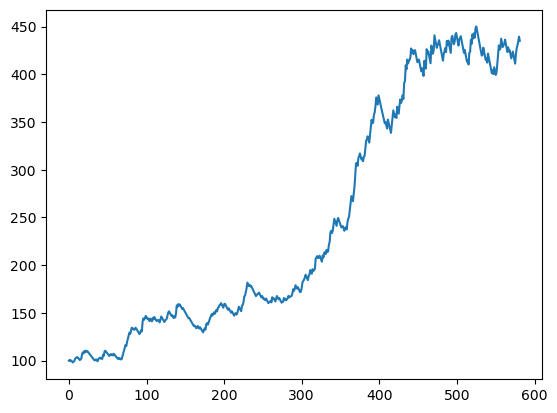

In [66]:
fig, ax = plt.subplots()
ax.plot(joined_fd['pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## Update to Single Prediction

In [67]:
dfs_preds_cut.head()

,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored_avg,team_goals_conceded_avg,team_goals_scored_avg_home,loss,draw,win,prediction,correct
0,1997-11-09,empoli,parma,0.00,1472.92,1551.84,-78.93,0.00,0.00,0.00,1.74,0.84,0.13,0.03,0.00,1
1,1997-11-09,brescia,milan,0.00,1498.15,1479.41,18.74,0.00,0.00,0.00,1.53,0.58,0.28,0.14,0.00,1
2,1997-11-09,bari,roma,0.00,1464.29,1525.65,-61.36,1.00,0.00,0.00,0.68,0.20,0.11,0.69,1.00,0
3,1997-11-09,piacenza,udinese,0.00,1433.15,1503.36,-70.21,0.00,0.00,0.00,0.84,0.81,0.15,0.04,0.00,1
4,1997-11-09,napoli,juventus,0.00,1441.46,1575.17,-133.71,1.00,0.00,0.00,0.79,0.30,0.24,0.47,1.00,0


In [68]:
odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
odds_fd = odds_fd.loc[:,~odds_fd.columns.str.contains('Unnamed')]
odds_fd.dropna(subset='home_team', inplace=True)
odds_fd['date'] = pd.to_datetime(odds_fd['date']).dt.date
odds_fd['home_team'] = odds_fd['home_team'].replace(' ', '_', regex=True).str.lower()
odds_fd['away_team'] = odds_fd['away_team'].replace(' ', '_', regex=True).str.lower()
odds_fd = odds_fd[['div', 'date', 'home_team', 'away_team', 'FTR', 'B365H', 'B365D', 'B365A']]
odds_fd.head()

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/931263150.py:1: DtypeWarning: Columns (3,11,118,145) have mixed types. Specify dtype option on import or set low_memory=False.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/931263150.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  odds_fd = pd.read_csv("../../data/serie_a_b_matches.csv", index_col=0, parse_dates=['date'], dayfirst=False)


,div,date,home_team,away_team,FTR,B365H,B365D,B365A
0,I1,2022-08-13,milan,udinese,H,1.44,4.75,7.00
1,I1,2022-08-13,sampdoria,atalanta,A,4.33,3.90,1.75
2,I1,2022-08-13,lecce,inter,A,10.00,5.75,1.28
3,I1,2022-08-13,monza,torino,A,2.60,3.30,2.75
4,I1,2022-08-14,fiorentina,cremonese,H,1.36,5.00,8.50


In [69]:
conditions  = [odds_fd['FTR']=='H', odds_fd['FTR']=='D', odds_fd['FTR']=='A']
choices     = [1, 0.5, 0]
odds_fd['FTR'] = np.select(conditions, choices)

In [70]:
odds_fd.rename(columns={'FTR': 'result',
                        'B365H': 'team_odds',
                        'B365A': 'opponent_odds',
                        'B365D': 'draw_odds'}, inplace=True)


In [71]:
dfs_preds_h_a = dfs_preds_cut.rename(columns={'loss': '0', 'draw': '1', 'win': '2'})

In [72]:
def transform_to_home_and_away(df):
    df['date'] = pd.to_datetime(df['date'])
    df_home = df[df['home'] == 1]
    df_away = df[df['home'] == 0]
    if 'result' in df_away.columns:
        df_away.drop('result', axis=1, inplace=True)

    df_home.rename(columns={'team': 'home_team', 'opponent': 'away_team', 'elo_team': 'elo_home', 'elo_opponent': 'elo_away',
                            '0': 'A', '1': 'D', '2': 'H'}, inplace=True)
    df_away.rename(columns={'team': 'away_team', 'opponent': 'home_team', 'elo_team': 'elo_away', 'elo_opponent': 'elo_home',
                            '0': 'H', '1': 'D', '2': 'A'}, inplace=True)

    df_combined = pd.concat([df_home, df_away])
    df_combined = df_combined.groupby(['date', 'home_team', 'away_team', 'elo_home', 'elo_away']).mean()
    df_combined.reset_index(inplace=True, drop=False)
    if 'result' in df_combined.columns:
        df_combined.drop(['result'], axis=1, inplace=True)
    df_combined['elo_diff'] = df_combined['elo_home'] - df_combined['elo_away']

    if 'team_goals_scored' not in df_home.columns:
        df_ftr = df_home.drop(['A', 'D', 'H', 'elo_diff', 'elo_home', 'elo_away', 'home'], axis=1)
        df_ftr['date'] = pd.to_datetime(df_ftr['date'])
    else:
        df_ftr = df_home.drop(['loss', 'draw', 'win', 'rest_days', 'team_goals_scored', 'opponent_goals_scored', 'elo_home', 'elo_away', 'home'], axis=1)
        df_ftr['date'] = pd.to_datetime(df_ftr['date'])

    df_combined = df_combined.merge(df_ftr, on=['date', 'home_team', 'away_team'], how='outer'
                                    )

    return df_combined

In [73]:
dfs_preds_h_a = transform_to_home_and_away(dfs_preds_h_a)
dfs_preds_h_a.head()

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/1402887065.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_away.drop('result', axis=1, inplace=True)
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/1402887065.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_home.rename(columns={'team': 'home_team', 'opponent': 'away_team', 'elo_team': 'elo_home', 'elo_opponent': 'elo_away',
/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/1402887065.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,team_goals_scored_avg_x,team_goals_conceded_avg_x,team_goals_scored_avg_home_x,...,D,H,prediction_x,correct_x,result,team_goals_scored_avg_y,team_goals_conceded_avg_y,team_goals_scored_avg_home_y,prediction_y,correct_y
0,1997-11-09,atalanta,inter_milan,1503.32,1594.04,-90.72,0.50,0.00,0.00,1.55,...,0.26,0.46,0.50,0.00,0.00,0.00,0.00,1.11,1.00,0.00
1,1997-11-09,bari,roma,1464.29,1525.65,-61.36,0.50,0.00,0.00,1.63,...,0.09,0.70,0.50,0.00,0.00,0.00,0.00,0.68,1.00,0.00
2,1997-11-09,fiorentina,lecce,1482.89,1451.65,31.24,0.50,0.00,0.00,1.53,...,0.15,0.80,0.50,1.00,1.00,0.00,0.00,2.05,1.00,1.00
3,1997-11-09,l_r_vicenza,bologna,1521.19,1469.31,51.88,0.50,0.00,0.00,1.58,...,0.15,0.79,0.50,1.00,1.00,0.00,0.00,1.21,1.00,1.00
4,1997-11-09,lazio,sampdoria,1517.31,1514.87,2.45,0.50,0.00,0.00,1.82,...,0.14,0.78,0.50,1.00,1.00,0.00,0.00,1.79,1.00,1.00


In [74]:
dfs_preds_h_a = dfs_preds_h_a.loc[:, ~dfs_preds_h_a.columns.str.contains('_x')]
dfs_preds_h_a = dfs_preds_h_a.loc[:, ~dfs_preds_h_a.columns.str.contains('_y')]
dfs_preds_h_a.head()

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,result
0,1997-11-09,atalanta,inter_milan,1503.32,1594.04,-90.72,0.50,0.28,0.26,0.46,0.00
1,1997-11-09,bari,roma,1464.29,1525.65,-61.36,0.50,0.21,0.09,0.70,0.00
2,1997-11-09,fiorentina,lecce,1482.89,1451.65,31.24,0.50,0.05,0.15,0.80,1.00
3,1997-11-09,l_r_vicenza,bologna,1521.19,1469.31,51.88,0.50,0.06,0.15,0.79,1.00
4,1997-11-09,lazio,sampdoria,1517.31,1514.87,2.45,0.50,0.08,0.14,0.78,1.00


In [75]:
dfs_preds_h_a['prediction'] = dfs_preds_h_a[['A', 'D', 'H']].idxmax(axis=1)
dfs_preds_h_a['prediction'] = dfs_preds_h_a['prediction'].replace({'H': 1, 'D': 0.5, 'A': 0})
dfs_preds_h_a['correct'] = np.where((dfs_preds_h_a['result'] == dfs_preds_h_a['prediction']), 1, 0)

In [76]:
dfs_preds_h_a['correct'].mean()

0.6003062368413857

In [77]:
dfs_preds_h_a['date'] = pd.to_datetime(dfs_preds_h_a['date']).dt.date
dfs_preds_h_a

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,result,prediction,correct
0,1997-11-09,atalanta,inter_milan,1503.32,1594.04,-90.72,0.50,0.28,0.26,0.46,0.00,1.00,0
1,1997-11-09,bari,roma,1464.29,1525.65,-61.36,0.50,0.21,0.09,0.70,0.00,1.00,0
2,1997-11-09,fiorentina,lecce,1482.89,1451.65,31.24,0.50,0.05,0.15,0.80,1.00,1.00,1
3,1997-11-09,l_r_vicenza,bologna,1521.19,1469.31,51.88,0.50,0.06,0.15,0.79,1.00,1.00,1
4,1997-11-09,lazio,sampdoria,1517.31,1514.87,2.45,0.50,0.08,0.14,0.78,1.00,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36568,2023-01-21,parma,perugia,1439.26,1414.88,24.38,0.50,0.14,0.59,0.26,0.50,0.50,1
36569,2023-01-21,reggina,ternana,1493.08,1445.95,47.13,0.50,0.11,0.75,0.14,0.50,0.50,1
36570,2023-01-21,spal,ascoli,1460.86,1437.72,23.14,0.50,0.12,0.72,0.16,0.50,0.50,1
36571,2023-01-21,venezia,sudtirol,1432.18,1505.93,-73.75,0.50,0.07,0.76,0.17,0.50,0.50,1


In [78]:
joined_h_a = pd.merge(dfs_preds_h_a, odds_fd,
                     left_on=['home_team', 'away_team', 'date', 'result'],
                     right_on=['home_team', 'away_team', 'date', 'result'],
                     how='inner')
joined_h_a.head()

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,result,prediction,correct,div,team_odds,draw_odds,opponent_odds
0,1997-11-22,piacenza,lazio,1421.14,1532.21,-111.07,0.50,0.31,0.51,0.18,0.50,0.50,1,I1,NaN,NaN,NaN
1,1997-11-23,bologna,fiorentina,1456.53,1496.54,-40.01,0.50,0.33,0.39,0.27,0.50,0.50,1,I1,NaN,NaN,NaN
2,1997-11-23,brescia,udinese,1482.34,1515.37,-33.03,0.50,0.46,0.35,0.19,0.00,0.00,1,I1,NaN,NaN,NaN
3,1997-11-23,empoli,atalanta,1461.27,1492.15,-30.89,0.50,0.31,0.32,0.37,1.00,1.00,1,I1,NaN,NaN,NaN
4,1997-11-23,juventus,parma,1584.66,1563.49,21.17,0.50,0.26,0.34,0.39,0.50,1.00,0,I1,NaN,NaN,NaN


In [79]:
joined_h_a = joined_h_a[joined_h_a['date']>=date]
joined_h_a.dropna(subset='team_odds', inplace=True)

/var/folders/bl/xbg_536n2_n123s38z4hxbx00000gn/T/ipykernel_28023/3096795386.py:1: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  joined_h_a = joined_h_a[joined_h_a['date']>=date]


In [80]:
joined_h_a.head()

,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,H,result,prediction,correct,div,team_odds,draw_odds,opponent_odds
7715,2020-09-19,fiorentina,torino,1559.04,1482.59,76.46,0.50,0.01,0.05,0.94,1.00,1.00,1,I1,1.83,3.75,4.20
7716,2020-09-20,genoa,crotone,1523.99,1530.30,-6.31,0.50,0.16,0.17,0.67,1.00,1.00,1,I1,1.90,3.60,4.00
7717,2020-09-20,juventus,sampdoria,1539.27,1500.08,39.19,0.50,0.09,0.16,0.75,1.00,1.00,1,I1,1.28,5.50,10.50
7718,2020-09-20,parma,napoli,1513.98,1597.03,-83.05,0.50,0.27,0.15,0.58,0.00,1.00,0,I1,5.25,4.20,1.61
7719,2020-09-20,sassuolo,cagliari,1547.87,1483.07,64.81,0.50,0.06,0.10,0.85,0.50,1.00,0,I1,1.95,3.75,3.75


In [81]:
def get_pred_odds(row):
    if row['prediction'] == 1:
        return row['team_odds']
    elif row['prediction'] == 0:
        return row['opponent_odds']
    else:
        return row['draw_odds']
    
joined_h_a['odds_bet'] = joined_h_a.apply(lambda x: get_pred_odds(x), axis=1)
joined_h_a['pot'] = 100
joined_h_a.reset_index(inplace=True)

In [82]:
joined_h_a['correct'].mean()

0.5628803245436106

In [88]:
# pot = [100]
# win = []
# bet_amt = 1

# for index, row in joined_h_a.iterrows():
#     if row['correct'] == 1:
#         round_winnings = row['odds_bet'] * bet_amt - bet_amt
#     else:
#         round_winnings = - bet_amt
#     win.append(round_winnings)
#     pot.append(round_winnings + pot[index])
    
# joined_h_a['pot'] = pot[:-1]
# joined_h_a['win'] = win

In [89]:
pot = [100]
win = []
bet_pct = 0.01

for index, row in joined_h_a.iterrows():
    if row['correct'] == 1:
#         round_winnings = row['odds_bet'] * bet_pct * pot[index] - bet_pct * pot[index]
        round_winnings = row['odds_bet'] - 1
    else:
#         round_winnings = - bet_pct * pot[index]
        round_winnings = - 1
    win.append(round_winnings)
    pot.append(round_winnings + pot[index])
    
joined_h_a['pot'] = pot[:-1]
joined_h_a['win'] = win

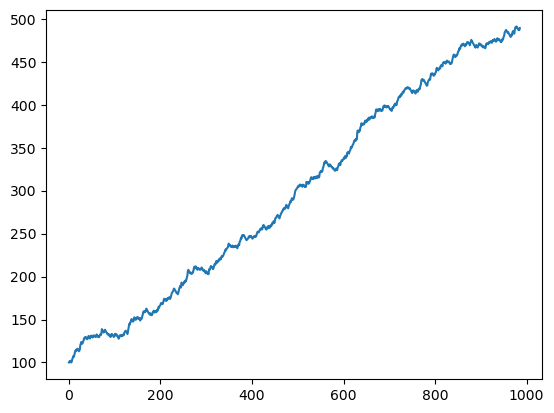

In [90]:
fig, ax = plt.subplots()
ax.plot(joined_h_a['pot'])
ax.ticklabel_format(useOffset=False, style='plain')
ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [91]:
joined_h_a.shape

(986, 21)

In [92]:
joined_h_a

,index,date,home_team,away_team,elo_home,elo_away,elo_diff,home,A,D,...,result,prediction,correct,div,team_odds,draw_odds,opponent_odds,odds_bet,pot,win
0,7715,2020-09-19,fiorentina,torino,1559.04,1482.59,76.46,0.50,0.01,0.05,...,1.00,1.00,1,I1,1.83,3.75,4.20,1.83,100.00,0.83
1,7716,2020-09-20,genoa,crotone,1523.99,1530.30,-6.31,0.50,0.16,0.17,...,1.00,1.00,1,I1,1.90,3.60,4.00,1.90,100.83,0.90
2,7717,2020-09-20,juventus,sampdoria,1539.27,1500.08,39.19,0.50,0.09,0.16,...,1.00,1.00,1,I1,1.28,5.50,10.50,1.28,101.73,0.28
3,7718,2020-09-20,parma,napoli,1513.98,1597.03,-83.05,0.50,0.27,0.15,...,0.00,1.00,0,I1,5.25,4.20,1.61,5.25,102.01,-1.00
4,7719,2020-09-20,sassuolo,cagliari,1547.87,1483.07,64.81,0.50,0.06,0.10,...,0.50,1.00,0,I1,1.95,3.75,3.75,1.95,101.01,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,8700,2022-12-26,como,cittadella,1400.49,1391.74,8.75,0.50,0.26,0.41,...,1.00,0.50,0,I2,2.25,3.10,3.40,3.10,488.13,-1.00
982,8701,2022-12-26,frosinone,ternana,1507.58,1442.13,65.45,0.50,0.18,0.40,...,1.00,1.00,1,I2,1.75,3.50,5.00,1.75,487.13,0.75
983,8702,2022-12-26,spal,pisa,1456.83,1483.03,-26.20,0.50,0.27,0.42,...,0.00,0.50,0,I2,2.63,3.10,2.70,3.10,487.88,-1.00
984,8703,2022-12-26,sudtirol,modena,1510.14,1497.75,12.39,0.50,0.52,0.27,...,0.00,0.00,1,I2,2.25,3.10,3.40,3.40,486.88,2.40


In [93]:
joined_h_a['prediction'].value_counts()

1.00    510
0.00    277
0.50    199
Name: prediction, dtype: int64